# Analysis of CDC (Center for Disease Control) cancer mortality data by US County

## Aims:
#### Analyzing relations between various socio-economical factors and cancer mortality and incidence rates to find racial and economical inequalities in health and acces to healthcare in the US
#### Creating regression model to predict cancer mortality on County level in current US socioeconomical climate


In [2]:
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

# preprocessing, feature and model selection
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler,PowerTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif,RFE, RFECV
from sklearn.pipeline import make_pipeline
import sklearn.pipeline as pipeline
from sklearn.model_selection import GridSearchCV,train_test_split,TimeSeriesSplit

#  models and metrics
import sklearn.linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn import metrics

# statistical libraries
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

# warnings
import warnings

# saving models
import pickle


# additional functions
from add_functions import fill_missing, find_best_algorytm, categorize , differences

### Reading data and first look

In [3]:
data = pd.read_csv(r"C:\Users\szklarnia\Desktop\datascience\dane\cancer_reg.csv")


In [4]:
data

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,...,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,...,54.9,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,...,53.3,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,...,52.6,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,...,56.3,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


In [5]:
data.columns

Index(['avganncount', 'avgdeathsperyear', 'target_deathrate', 'incidencerate',
       'medincome', 'popest2015', 'povertypercent', 'studypercap', 'binnedinc',
       'medianage', 'medianagemale', 'medianagefemale', 'geography',
       'avghouseholdsize', 'percentmarried', 'pctnohs18_24', 'pcths18_24',
       'pctsomecol18_24', 'pctbachdeg18_24', 'pcths25_over',
       'pctbachdeg25_over', 'pctemployed16_over', 'pctunemployed16_over',
       'pctprivatecoverage', 'pctprivatecoveragealone', 'pctempprivcoverage',
       'pctpubliccoverage', 'pctpubliccoveragealone', 'pctwhite', 'pctblack',
       'pctasian', 'pctotherrace', 'pctmarriedhouseholds', 'birthrate'],
      dtype='object')

Descriptive statistics

In [4]:
data.describe()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,...,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
count,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3.047000e+03,3047.000000,3047.000000,3047.000000,3047.000000,...,2438.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000
mean,606.338544,185.965868,178.664063,448.268586,47063.281917,1.026374e+05,16.878175,155.399415,45.272333,39.570725,...,48.453774,41.196324,36.252642,19.240072,83.645286,9.107978,1.253965,1.983523,51.243872,5.640306
std,1416.356223,504.134286,27.751511,54.560733,12040.090836,3.290592e+05,6.409087,529.628366,45.304480,5.226017,...,10.083006,9.447687,7.841741,6.113041,16.380025,14.534538,2.610276,3.517710,6.572814,1.985816
min,6.000000,3.000000,59.700000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,22.300000,22.400000,...,15.700000,13.500000,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000
25%,76.000000,28.000000,161.200000,420.300000,38882.500000,1.168400e+04,12.150000,0.000000,37.700000,36.350000,...,41.000000,34.500000,30.900000,14.850000,77.296180,0.620675,0.254199,0.295172,47.763063,4.521419
50%,171.000000,61.000000,178.100000,453.549422,45207.000000,2.664300e+04,15.900000,0.000000,41.000000,39.600000,...,48.700000,41.100000,36.300000,18.800000,90.059774,2.247576,0.549812,0.826185,51.669941,5.381478
75%,518.000000,149.000000,195.200000,480.850000,52492.000000,6.867100e+04,20.400000,83.650776,44.000000,42.500000,...,55.600000,47.700000,41.550000,23.100000,95.451693,10.509732,1.221037,2.177960,55.395132,6.493677
max,38150.000000,14010.000000,362.800000,1206.900000,125635.000000,1.017029e+07,47.400000,9762.308998,624.000000,64.700000,...,78.900000,70.700000,65.100000,46.600000,100.000000,85.947799,42.619425,41.930251,78.075397,21.326165


## 1. Analysis of socioeconomical factors impacting cancer mortality rates

### 1.1 Differences in cancer mortality by percentage of black citizens in a county

In [5]:
## first, lets check descriptive stats of black population percentage

data.pctblack.describe()

count    3047.000000
mean        9.107978
std        14.534538
min         0.000000
25%         0.620675
50%         2.247576
75%        10.509732
max        85.947799
Name: pctblack, dtype: float64

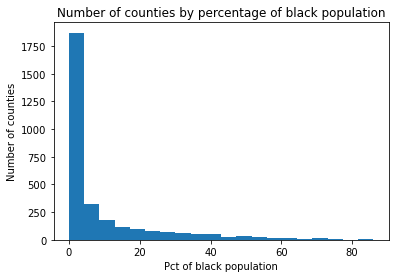

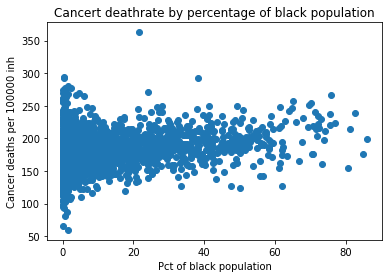

In [8]:
#histogram of black population percentage and cancer death rates by black pop. percentage
plt.hist(data.pctblack,bins=20)
plt.title("Number of counties by percentage of black population")
plt.xlabel("Pct of black population")
plt.ylabel("Number of counties")
plt.show()
plt.scatter(data.pctblack,data.target_deathrate)
plt.title("Cancert deathrate by percentage of black population")
plt.xlabel("Pct of black population")
plt.ylabel("Cancer deaths per 100000 inh")
plt.show()

Most of the counties have under 4% of black population. However there are some counties with heavy black black majority. On a plot showing correlation between percentage of black population and cancer death rate there seems to be small positive correlation, subject to further testing. For further tests data will be divided into four categories, for counties with less than 1% black population, less than 10%, less than 50% and higher than 50%. Groups won't be equally numerous, as the distribution of pctblack variable is very oblique

In [4]:
# categorizing data
pct_black_cat = categorize(data,"pctblack","target_deathrate",[1,10,50])

In [5]:
# printing out means deathrate for categories
for category in pct_black_cat:
    result = pct_black_cat[category].mean()
    print(f"Mean death rate per 100000 inhabitants for category {category} is {result}")


Mean death rate per 100000 inhabitants for category Under 1 is 172.65918367346913
Mean death rate per 100000 inhabitants for category Over 1 is 177.50414201183432
Mean death rate per 100000 inhabitants for category Over 10 is 186.77304347826086
Mean death rate per 100000 inhabitants for category Over 50 is 202.10416666666663


Mean death rate grows with growing percentage of black population. Further tests will show if the difference is statistically significant

In [6]:
# preparing arras for statistical testing
array1, array2,array3, array4 = pct_black_cat.values()

In [7]:
# statistical testing
differences(pct_black_cat,array1, array2,array3, array4)

Levene test result = LeveneResult(statistic=17.314119263781524, pvalue=3.804543855636038e-11)
----
Unequal variances, performing kruskall wallis test

KruskalResult(statistic=199.60973218025765, pvalue=5.122570061843188e-43)

Differences between groups, performing post hoc ttests
{('Over 1', 'Over 10'): 'Ttest_indResult(statistic=-8.04898478077863, '
                        'pvalue=1.6540896272866057e-15) \n',
 ('Over 1', 'Over 50'): 'Ttest_indResult(statistic=-8.243273884652549, '
                        'pvalue=4.432609950799515e-13) \n',
 ('Over 1', 'Under 1'): 'Ttest_indResult(statistic=4.089858601857582, '
                        'pvalue=4.4792420325032e-05) \n',
 ('Over 10', 'Over 1'): 'Ttest_indResult(statistic=8.04898478077863, '
                        'pvalue=1.6540896272866057e-15) \n',
 ('Over 10', 'Over 50'): 'Ttest_indResult(statistic=-5.068148896975147, '
                         'pvalue=1.5736577761049696e-06) \n',
 ('Over 10', 'Under 1'): 'Ttest_indResult(statistic=10.

Every single ttest has significant results. It means that with increase of black population in county, cancer death rates are becoming higher and higher. It would mean that black citizens are more likely to die of cancer than others. We can pose more questions: does these counties have simply higher cancer illness rates or are they also receiving worse treatment (have higher proportion of yearly deaths to yearly rates?

In [12]:
#categorizing data with different key variable - incidencerate
pct_black_cat = categorize(data,"pctblack","incidencerate",[1,10,50])

for category in pct_black_cat:
    result = pct_black_cat[category].mean()
    print(f"Mean incidence rate per 100000 inhabitants for category {category} is {result}")

Mean incidence rate per 100000 inhabitants for category Under 1 is 439.7790626124317
Mean incidence rate per 100000 inhabitants for category Over 1 is 448.7928185510563
Mean incidence rate per 100000 inhabitants for category Over 10 is 458.85499581231943
Mean incidence rate per 100000 inhabitants for category Over 50 is 461.04895833333325


Again, incidence rate is growing with growing proportion of black citizens

In [13]:
array1, array2,array3, array4 = pct_black_cat.values()

differences(pct_black_cat,array1, array2,array3, array4)

Levene test result = LeveneResult(statistic=2.9089336340273393, pvalue=0.03331900734859659)
----
Unequal variances, performing kruskall wallis test

KruskalResult(statistic=54.361294132811985, pvalue=9.396353560886622e-12)

Differences between groups, performing post hoc ttests
{('Over 1', 'Over 10'): 'Ttest_indResult(statistic=-3.813660946497363, '
                        'pvalue=0.0001433138089237598) \n',
 ('Over 1', 'Over 50'): 'Ttest_indResult(statistic=-2.272304540826404, '
                        'pvalue=0.024993836534655606) \n',
 ('Over 1', 'Under 1'): 'Ttest_indResult(statistic=4.011160700163226, '
                        'pvalue=6.244922528831411e-05) \n',
 ('Over 10', 'Over 1'): 'Ttest_indResult(statistic=3.813660946497363, '
                        'pvalue=0.0001433138089237598) \n',
 ('Over 10', 'Over 50'): 'Ttest_indResult(statistic=-0.38982100187118396, '
                         'pvalue=0.6973013566093795) \n',
 ('Over 10', 'Under 1'): 'Ttest_indResult(statistic=6.9043

Ttest show that higher cancer incidence rate is tied to higher pct of black citizens in counties, however only to the 10% threshold. There is no statistical difference between groups Over 10 and Over 50. What about incidence/death ratio?

In [15]:
# ratio per category
pct_black_cat = categorize(data,"pctblack",["incidencerate","target_deathrate"],[1,10,50])

for category in pct_black_cat:
    result = pct_black_cat[category].target_deathrate.mean() / pct_black_cat[category].incidencerate.mean()
    print(f"Mean incidence rate per 100000 inhabitants for category {category} is {result}")


Mean incidence rate per 100000 inhabitants for category Under 1 is 0.39260437422331346
Mean incidence rate per 100000 inhabitants for category Over 1 is 0.39551466662259166
Mean incidence rate per 100000 inhabitants for category Over 10 is 0.40704153857497644
Mean incidence rate per 100000 inhabitants for category Over 50 is 0.43835727857896506


Now let's visualise relation between pct of black citizens, poverty rates and median income

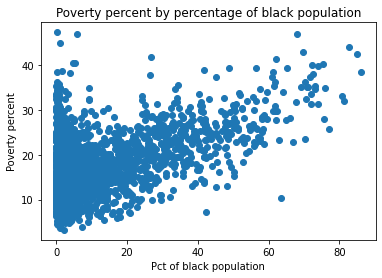

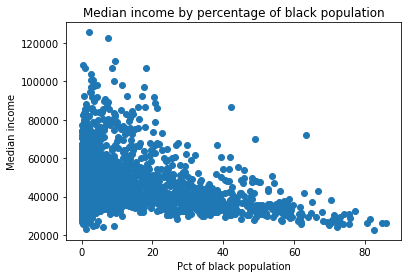

In [10]:
plt.scatter(data.pctblack,data.povertypercent)
plt.title("Poverty percent by percentage of black population")
plt.xlabel("Pct of black population")
plt.ylabel("Poverty percent")
plt.show()

plt.scatter(data.pctblack,data.medincome)
plt.title("Median income by percentage of black population")
plt.xlabel("Pct of black population")
plt.ylabel("Median income")
plt.show()

In [11]:
print(f"Correlation value between pct of black popularion and poverty rate is: {stats.pearsonr(data.pctblack,data.povertypercent)}")
print(f"Correlation value between pct of black popularion and poverty rate is: {stats.pearsonr(data.pctblack,data.medincome)}")

Correlation value between pct of black popularion and poverty rate is: (0.5115296628242751, 7.393986552383893e-203)
Correlation value between pct of black popularion and poverty rate is: (-0.2702316192292904, 3.8686135980687544e-52)


There is a medium strong positive correlation between poverty rates and percentage of black citizens, and medium weak negative correlation between percentage of black citizens and median income. I would argue that most of the differences in cancer incidence and mortality rates in counties with high black population percentage are primarily caused by income disparities.

#### Overall results of statistical analysys show, that in counties with higher percentage of black population cancer incidence rates are significantly higher than in those with lower pct. Moreover, citizens in those counties are receiving worse quality healthcare, resulting in higher death rate. It indicates that black citizens in usa have worse acces to quality healthcare and higher chance of dying from cancer than other groups

### 1.2  Differences in cancer mortality by percentage of citizens in poverty by county

In [27]:
#descriptive stats
data.povertypercent.describe()

count    3047.000000
mean       16.878175
std         6.409087
min         3.200000
25%        12.150000
50%        15.900000
75%        20.400000
max        47.400000
Name: povertypercent, dtype: float64

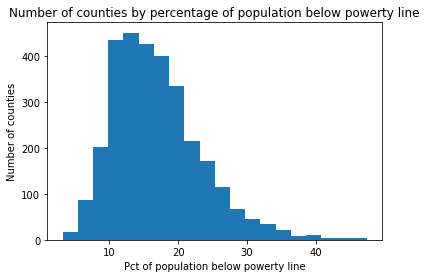

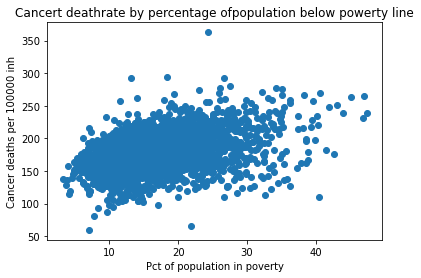

In [17]:
# plots
plt.hist(data.povertypercent,bins=20)
plt.title("Number of counties by percentage of population below powerty line")
plt.xlabel("Pct of population below powerty line")
plt.ylabel("Number of counties")
plt.show()
plt.scatter(data.povertypercent,data.target_deathrate)
plt.title("Cancert deathrate by percentage ofpopulation below powerty line")
plt.xlabel("Pct of population in poverty")
plt.ylabel("Cancer deaths per 100000 inh")
plt.show()

In most counties, percent of citizens living in poverty is around 15. Correlation plot signifies a positive correlation, subjet to further testing. Data will be divided into categories by quartiles, to create data with equal number of samples

In [6]:
## Dividing data in four groups: poverty percent less than 10 percent, less than 15 percent, less than 20 and higher than 20
poverty_categories = categorize(data,"povertypercent",["incidencerate","target_deathrate"],[10,15,20])

In [7]:
## Means in each category

for category in poverty_categories:
    result = poverty_categories[category].target_deathrate.mean()
    print(f"Mean death rate per 100000 inhabitants for category {category} is {result}")

Mean death rate per 100000 inhabitants for category Under 10 is 158.6845272206304
Mean death rate per 100000 inhabitants for category Over 10 is 170.15838264299782
Mean death rate per 100000 inhabitants for category Over 15 is 182.6727797001154
Mean death rate per 100000 inhabitants for category Over 20 is 193.50134638922842


Again, mean cancer mortality rates are growing with increasing number of poor citizens. This information will be subjeted to further statistical testing

In [9]:
# statistical tests
array1, array2,array3, array4 = poverty_categories.values()

differences(poverty_categories,array1.target_deathrate, array2.target_deathrate,array3.target_deathrate, array4.target_deathrate)

Levene test result = LeveneResult(statistic=31.955441982830905, pvalue=2.4812852169243566e-20)
----
Unequal variances, performing kruskall wallis test

KruskalResult(statistic=553.8049531657143, pvalue=1.0403583618801608e-119)

Differences between groups, performing post hoc ttests
{('Over 10', 'Over 15'): 'Ttest_indResult(statistic=array([ -1.95906151, '
                         '-11.75339795]), pvalue=array([5.02570870e-02, '
                         '8.34714682e-31])) \n',
 ('Over 10', 'Over 20'): 'Ttest_indResult(statistic=array([  0.63720194, '
                         '-17.90726322]), pvalue=array([5.24098515e-01, '
                         '4.91231389e-65])) \n',
 ('Over 10', 'Under 10'): 'Ttest_indResult(statistic=array([1.11571772, '
                          '8.44124238]), pvalue=array([2.65021653e-01, '
                          '2.07145298e-16])) \n',
 ('Over 15', 'Over 10'): 'Ttest_indResult(statistic=array([ 1.95906151, '
                         '11.75339795]), pvalue=ar

There are significant statistical differences indicating that mortality rates are higher in areas with higher poverty rates

In [25]:
# testing data by median income
data.medincome.describe()

count      3047.000000
mean      47063.281917
std       12040.090836
min       22640.000000
25%       38882.500000
50%       45207.000000
75%       52492.000000
max      125635.000000
Name: medincome, dtype: float64

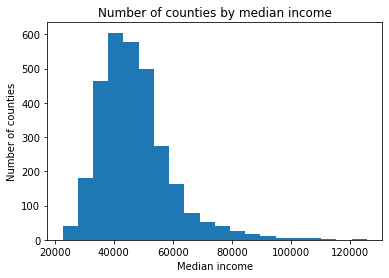

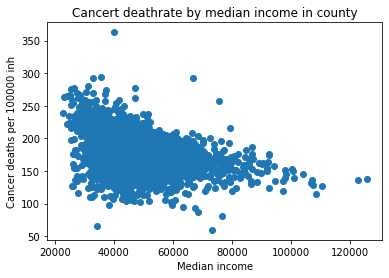

In [26]:
# plots
plt.hist(data.medincome,bins=20)
plt.title("Number of counties by median income")
plt.xlabel("Median income")
plt.ylabel("Number of counties")
plt.show()
plt.scatter(data.medincome,data.target_deathrate)
plt.title("Cancert deathrate by median income in county")
plt.xlabel("Median income")
plt.ylabel("Cancer deaths per 100000 inh")
plt.show()

In most counties median income is around 45000 dolars per year. Correlation plot suggests negative correlation between cancer deathrates and median income in a county. Data will be divided in four groups.

In [37]:
# categorizing
median_categories = categorize(data,"medincome","target_deathrate",[30000,45000,60000])

In [38]:
for category in median_categories:
    result = median_categories[category].mean()
    print(f"Mean death rate per 100000 inhabitants for median income category {category} is {result}")

Mean death rate per 100000 inhabitants for median income category Under 30000 is 212.85443037974684
Mean death rate per 100000 inhabitants for median income category Over 30000 is 187.8085211267604
Mean death rate per 100000 inhabitants for median income category Over 45000 is 171.00266889074226
Mean death rate per 100000 inhabitants for median income category Over 60000 is 160.0389684813754


In [39]:
# statistical testing
array1, array2,array3, array4 = median_categories.values()

differences(median_categories,array1, array2,array3, array4)

Levene test result = LeveneResult(statistic=29.108532486075347, pvalue=1.4991277084380897e-18)
----
Unequal variances, performing kruskall wallis test

KruskalResult(statistic=549.2121810851282, pvalue=1.029648361860257e-118)

Differences between groups, performing post hoc ttests
{('Over 30000', 'Over 45000'): 'Ttest_indResult(statistic=17.530585866457187, '
                               'pvalue=3.936960609271896e-65) \n',
 ('Over 30000', 'Over 60000'): 'Ttest_indResult(statistic=19.164911045135675, '
                               'pvalue=2.76496712974301e-64) \n',
 ('Over 30000', 'Under 30000'): 'Ttest_indResult(statistic=-5.427143179847457, '
                                'pvalue=5.686248462189906e-07) \n',
 ('Over 45000', 'Over 30000'): 'Ttest_indResult(statistic=-17.530585866457187, '
                               'pvalue=3.936960609271896e-65) \n',
 ('Over 45000', 'Over 60000'): 'Ttest_indResult(statistic=7.816385902564969, '
                               'pvalue=2.91197852

Cancer rates get significantly lower with the rise in median income. This is another confirmation of american inequalities. Again, incidence rates will be tested

In [43]:

# mean incidence rates per income groups
median_categories = categorize(data,"medincome","incidencerate",[30000,45000,60000])
for category in median_categories:
    result = median_categories[category].mean()
    print(f"Mean incidence rate per 100000 inhabitants for category {category} is {result}")

Mean incidence rate per 100000 inhabitants for category Under 30000 is 459.7607594936708
Mean incidence rate per 100000 inhabitants for category Over 30000 is 446.61135736753465
Mean incidence rate per 100000 inhabitants for category Over 45000 is 449.81006644862373
Mean incidence rate per 100000 inhabitants for category Over 60000 is 447.1142802830942


In [44]:
array1, array2,array3, array4 = median_categories.values()

differences(median_categories,array1, array2,array3, array4)

Levene test result = LeveneResult(statistic=17.6750878230925, pvalue=2.2562258649845606e-11)
----
Unequal variances, performing kruskall wallis test

KruskalResult(statistic=4.518830060767567, pvalue=0.21061682606185259)

No significant difference between groups


Interestingly, mean income in county does not directly affect cancer incidence rates. It would mean that what kills is not higher amount of cancer cases, but worse quality healthcare available to lower income citizens. Let's check case/death ratio


In [45]:
# mean death/incident ratio
median_categories = categorize(data,"medincome",["incidencerate","target_deathrate"],[30000,45000,60000])

for category in median_categories:
    result = median_categories[category].target_deathrate.mean() / median_categories[category].incidencerate.mean()
    print(f"Mean ratio for category {category} is {result}")

Mean ratio for category Under 30000 is 0.46296780659176084
Mean ratio for category Over 30000 is 0.4205189098498566
Mean ratio for category Over 45000 is 0.38016638942933434
Mean ratio for category Over 60000 is 0.3579375017502133


#### Statistical tests imply that there is a significant difference in cancer deathrates between counties with lower and hihger income and poverty percentage. Suprisingly, the incidence rate is not different between income groups. The real difference here is tied to healthcare access, as couties with lower median income have higher death/incident ratio. Further analysis will show how these numbers are tied to healthcare insurance provider

## 1.3 Cancer incidence and deathrates by healthcare insurance provider

In [49]:
healthcare_categories = categorize(data,"medincome",["target_deathrate","pctprivatecoverage", 'pctprivatecoveragealone', 'pctempprivcoverage',
       'pctpubliccoverage', 'pctpubliccoveragealone',"medincome"],[30000,45000,60000])

In [55]:
#mean percent of insured by provider per income categories
for category in healthcare_categories:
    print(category)
    print(healthcare_categories[category].mean())

Under 30000
target_deathrate             212.854430
pctprivatecoverage            42.678481
pctprivatecoveragealone       30.028571
pctempprivcoverage            26.089873
pctpubliccoverage             50.231646
pctpubliccoveragealone        32.568354
medincome                  27583.772152
dtype: float64
Over 30000
target_deathrate             187.808521
pctprivatecoverage            58.235000
pctprivatecoveragealone       42.172511
pctempprivcoverage            35.770915
pctpubliccoverage             40.698239
pctpubliccoveragealone        22.561690
medincome                  38746.709859
dtype: float64
Over 45000
target_deathrate             171.002669
pctprivatecoverage            69.549291
pctprivatecoveragealone       53.070674
pctempprivcoverage            44.922602
pctpubliccoverage             33.272644
pctpubliccoveragealone        16.519766
medincome                  51093.156797
dtype: float64
Over 60000
target_deathrate             160.038968
pctprivatecoverage            

In [58]:
# Focusing on data for low income counties
low = healthcare_categories["Under 30000"]


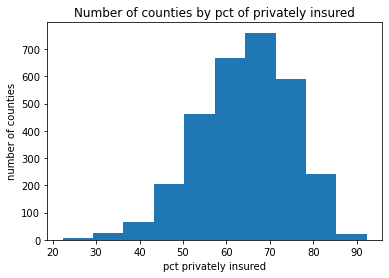

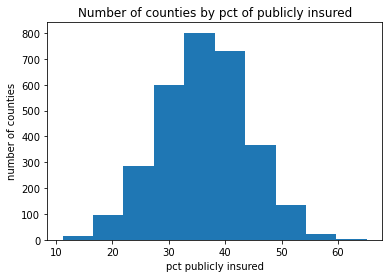

In [59]:
#histogram by percentage of insurance provider
plt.hist(data.pctprivatecoverage)
plt.title("Number of counties by pct of privately insured")
plt.xlabel("pct privately insured")
plt.ylabel("number of counties")
plt.show()
plt.hist(data.pctpubliccoverage)
plt.title("Number of counties by pct of publicly insured")
plt.xlabel("pct publicly insured")
plt.ylabel("number of counties")
plt.show()

Distributions are close to normal.

In [12]:
# percentage of privately insured by income
plt.scatter(low.medincome,low.pctprivatecoverage)
plt.title("Pct of privately insured by median income in low income group")
plt.xlabel("Med income")
plt.ylabel("Pct of privately insured")
plt.show()
plt.scatter(data.medincome,data.pctprivatecoverage)
plt.title("Pct of privately insured by median income in all income group")
plt.xlabel("Med income")
plt.ylabel("Pct of privately insured")
plt.show()


NameError: name 'low' is not defined

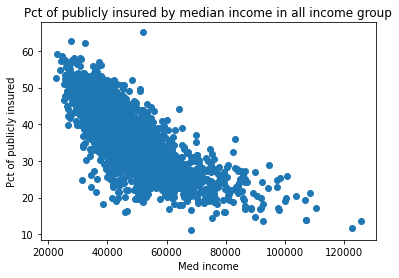

In [13]:
# percentage of publicly insured by income

plt.scatter(data.medincome,data.pctpubliccoverage)
plt.title("Pct of publicly insured by median income in all income group")
plt.xlabel("Med income")
plt.ylabel("Pct of publicly insured")
plt.show()

Percentage of privately and publicly insured is heavily correlated with median income, something worth remembering when comparing cancer deathrates by healthcare provider

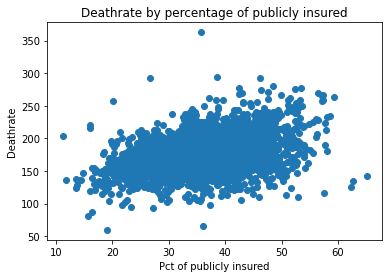

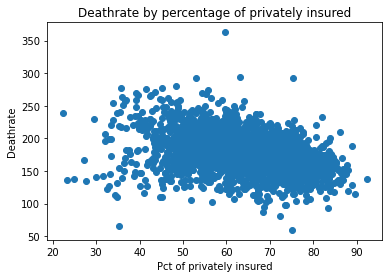

In [14]:
# cancer deathrate by number of publicly and privately insured
plt.scatter(data.pctpubliccoverage,data.target_deathrate)
plt.title("Deathrate by percentage of publicly insured")
plt.xlabel("Pct of publicly insured")
plt.ylabel("Deathrate")
plt.show()
plt.scatter(data.pctprivatecoverage,data.target_deathrate)
plt.title("Deathrate by percentage of privately insured")
plt.xlabel("Pct of privately insured")
plt.ylabel("Deathrate")
plt.show()

There seems to be clearly visible correlation between pct of privately and publicly insured and cancer deathrate. Let's run a tt
est between low and high percentage of privately and publicly insured to make sure that the effect is statisticly important

In [63]:
#ttest
stats.ttest_ind(data[data.pctpubliccoverage < 20].target_deathrate,data[data.pctpubliccoverage > 45].target_deathrate)

Ttest_indResult(statistic=-11.915712259754685, pvalue=1.260071102590432e-28)

There is clear difference between pct of publicly insured and death rate. Now let's look how public insurance is tied to quality of healthcare provided, as incidence/death rate.

These numbers can be seen as a proof of the fact that public isurance provides lower quality healthcare, thus private insurance is better than public. These conclusions are premature. We must take into account, that higher percentage of publicly insured is very much tied to median income in county. In USA public insurance is not universal but rather a for of federal help to poorer citizens. These numbers are very similar to the numbers seen in comparing incidence/death ratio between median income groups. People insured publicly certainly dont have additional money they could spend on higher quality treatments and this explanation seems more probable. Further analysis of concrete cases, not on the level of county could prove useful in drawing more detailed conclusions

### Analyses conducted above show many inequalities in access to healthcare and in possibility of getting cancer between groups in united states. Black citizens are more likely to get cancer and to die from int than the rest of population. We can also see difference in acces to quality healthcare between richer and poorer counties and between privately and publicly insured. This data is a valuable resource to anyone willing to tackle these inequalities

# Prediction

### Creation and evaluation of models

In [64]:
data.isna().sum()


avganncount                   0
avgdeathsperyear              0
target_deathrate              0
incidencerate                 0
medincome                     0
popest2015                    0
povertypercent                0
studypercap                   0
binnedinc                     0
medianage                     0
medianagemale                 0
medianagefemale               0
geography                     0
avghouseholdsize              0
percentmarried                0
pctnohs18_24                  0
pcths18_24                    0
pctsomecol18_24            2285
pctbachdeg18_24               0
pcths25_over                  0
pctbachdeg25_over             0
pctemployed16_over          152
pctunemployed16_over          0
pctprivatecoverage            0
pctprivatecoveragealone     609
pctempprivcoverage            0
pctpubliccoverage             0
pctpubliccoveragealone        0
pctwhite                      0
pctblack                      0
pctasian                      0
pctother

In [65]:
#removing columns with lots of nans, binnedinc as it carries the same info as medincome, and geography as it's not relevant to our analisys
data_removed = data.drop(["pctsomecol18_24","pctprivatecoveragealone","binnedinc","geography"],axis=1)

X = data_removed.iloc[:,3:]
y = data_removed.target_deathrate



X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

##### handling missing data

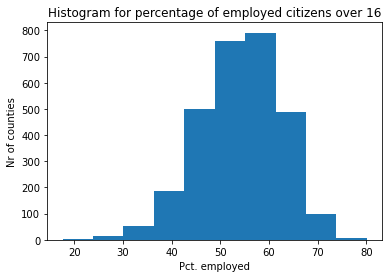

Mean of columns is: 54.15264248704645, median: 54.5


In [66]:
# filling missing data for pctemployed16_over

# checking the distribution
plt.hist(data["pctemployed16_over"])
plt.title("Histogram for percentage of employed citizens over 16")
plt.xlabel("Pct. employed")
plt.ylabel("Nr of counties")
plt.show()

print(f"Mean of columns is: {data.pctemployed16_over.mean()}, median: {data.pctemployed16_over.median()}")


We will try to fill missing values by predicting them based on other features. R2 score threshold for useful prediction is set to 0.6

In [67]:
X_train = fill_missing(X_train,"pctemployed16_over")
X_test = fill_missing(X_test,"pctemployed16_over")

C:\Users\szklarnia\anaconda3\lib\site-packages\pandas\core\series.py:4433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\szklarnia\anaconda3\lib\site-packages\pandas\core\series.py:4433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Creating pipelines in order: polynomial features, scaling, feature selection and predicting algorythm.

Feature selection based on linear regression model with l1 penalty, as it zeroes coeficients for features that have no effect on prediction. Other regularization algorytms don't eliminate features, so passing only relevant data should help with better results

In [71]:
# creating pipelines and param grids
import sklearn.linear_model

pipelines =[make_pipeline(PolynomialFeatures(),StandardScaler(),RFECV(Lasso(),cv=3),Ridge()),
            make_pipeline(PolynomialFeatures(),MinMaxScaler(),RFECV(Lasso(),cv=3),Ridge()),
            make_pipeline(PolynomialFeatures(),StandardScaler(),RFECV(Lasso(),cv=3),Lasso()),
            make_pipeline(PolynomialFeatures(),MinMaxScaler(),RFECV(Lasso(),cv=3),Lasso()),
            make_pipeline(PolynomialFeatures(),StandardScaler(),RFECV(Lasso(),cv=3),ElasticNet()),
            make_pipeline(PolynomialFeatures(),MinMaxScaler(),RFECV(Lasso(),cv=3),ElasticNet())]

param_grids = [{"polynomialfeatures__degree":[1,2],"ridge__alpha":[0.0001,0.001,0.01,0.1,1,10,100]},
              {"polynomialfeatures__degree":[1,2],"ridge__alpha":[0.0001,0.001,0.01,0.1,1,10,100]},
              {"polynomialfeatures__degree":[1,2],"lasso__alpha":[0.0001,0.001,0.01,0.1,1,10,100]},
              {"polynomialfeatures__degree":[1,2],"lasso__alpha":[0.0001,0.001,0.01,0.1,1,10,100]},
              {"polynomialfeatures__degree":[1,2],"elasticnet__alpha":[0.0001,0.001,0.01,0.1,1,10,100],"elasticnet__l1_ratio":[0.1,0.3,0.5,0.7,0.9]},
              {"polynomialfeatures__degree":[1,2],"elasticnet__alpha":[0.0001,0.001,0.01,0.1,1,10,100],"elasticnet__l1_ratio":[0.1,0.3,0.5,0.7,0.9]}]

In [ ]:
# Evaluation of models using GridSearchCV

best_model_singular = find_best_algorytm(X_train,X_test,y_train,y_test,pipelines,param_grids)


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done  70 out of  70 | elapsed:  8.7min finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  65 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done  70 out of  70 | elapsed:  4.3min finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 tasks      | elapsed:  5.9min
[Parallel(n_jobs=3)]: Done  70 out of  70 | elapsed:  8.7min finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 tasks      | elapsed:  2.9min
[Parallel(n_jobs=3)]: Done  70 out of  70 | elapsed:  4.3min finished


Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 tasks      | elapsed:  5.8min
[Parallel(n_jobs=3)]: Done 200 tasks      | elapsed: 23.2min
[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed: 41.5min finished


Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done 200 tasks      | elapsed: 12.6min


Now we will try random forest regressor

Random forest is trained independently to see which method - bagging or single is more efficient
For random forest we don't perform feature selection, as tree's have their own way of reducing number of features

In [6]:
rf_pipeline = pipeline.Pipeline([("scaler",StandardScaler()),
                      ("forest",RandomForestRegressor())])
rf_params = {"forest__n_estimators":[100,200],
             "forest__criterion":["mse","mae"],
             "forest__max_depth":[None,5,10,20],
            "forest__min_samples_split":[2,4,6,8],
            "forest__min_samples_leaf":[1,2,3,4]}

In [7]:

best_model_forrest = find_best_algorytm(X_train,X_test,y_train,y_test,rf_pipelin,rf_params)


Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   44.7s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:  9.8min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 53.6min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed: 133.1min
[Parallel(n_jobs=2)]: Done 1280 out of 1280 | elapsed: 166.6min finished


Best model is {'forest__criterion': 'mse', 'forest__max_depth': None, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 2, 'forest__n_estimators': 200} with R2 score: 0.5117359962286792


Random forest did not achieve better score, however we can test the best model with higher polynomial and more estimators

In [11]:
# fitting forest model with higher polynomial
best_forest = make_pipeline(PolynomialFeatures(2),StandardScaler(),RandomForestRegressor(criterion="mse",
                                                                                     max_depth = None,
                                                                                     min_samples_leaf=2,
                                                                                     n_estimators=200,
                                                                                     min_samples_split=2))
best_forest.fit(X_train,y_train)
best_forest.score(X_test,y_test)

0.5049255817961862

In [14]:
# fitting forest model with more estimators
best_forest = make_pipeline(StandardScaler(),RandomForestRegressor(criterion="mse",
                                                                                     max_depth = None,
                                                                                     min_samples_leaf=2,
                                                                                     n_estimators=1000,
                                                                                     min_samples_split=2))
best_forest.fit(X_train,y_train)
best_forest.score(X_test,y_test)

0.5191565170343635

In [16]:
# fitting best model on whole dataset
best_one = make_pipeline(PolynomialFeatures(2),StandardScaler(),RFECV(linear_model.Lasso(),cv=3),linear_model.Lasso(alpha=.001))
best_one.fit(X,y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('rfecv', RFECV(cv=3, estimator=Lasso())),
                ('lasso', Lasso(alpha=0.001))])

In [19]:
# saving best model
filename = 'Cancer_rates_prediction.sav'
pickle.dump(best_one,open(filename, 'wb'))

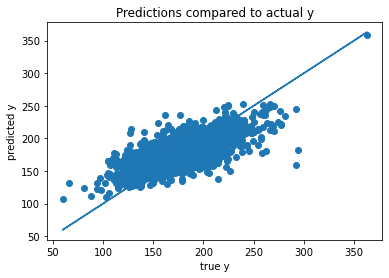

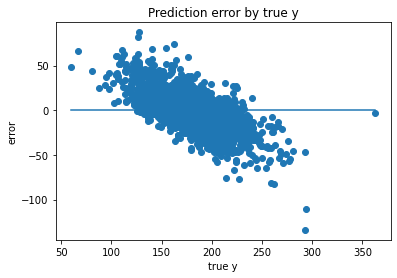

In [20]:
# plotting errors

# prediction vs actual
plt.scatter(y,best_one.predict(X),label="predicts")
plt.plot(y,y,label="y y reference")
plt.title("Predictions compared to actual y")
plt.xlabel("true y")
plt.ylabel("predicted y")
plt.show()

# error for true y
plt.scatter(y,best_one.predict(X)-y,label="predicts")
plt.plot(np.linspace(min(y),max(y)),np.zeros(50))
plt.title("Prediction error by true y")
plt.xlabel("true y")
plt.ylabel("error")
plt.show()

In [21]:
# Metrics for the best model
print(f"Root mean squared error of model: {np.sqrt(metrics.mean_squared_error(y,best_one.predict(X)))}")
print(f"Mean absolute error of model: {metrics.mean_absolute_error(y,best_one.predict(X))}")
print(f"Median absolute error of model: {metrics.median_absolute_error(y,best_one.predict(X))}")

Root mean squared error of model: 19.121632867904108
Mean absolute error of model: 14.18786353758478
Median absolute error of model: 10.54914233502413


Best model is overpredicting for lower y values and underpredicting for higher ones. With that in mind you could use that model to find counties that will need more resources to fight cancer. Bear in mind that this model can be applied with some confidence only in US, as it's based on socioeconomical data that is unique to american society (for ex. pct of black population - it would be useless in black majority countries)